### In case you encounter any problem running the notebook you can run the file "firespread_cnn.py"

In [ ]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm
import tensorflow as tf
from scipy.stats import rankdata

from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, Conv2DTranspose, Input, BatchNormalization, UpSampling2D, 
    MaxPooling2D, Dropout, Add, Flatten, Dense, Reshape, ReLU, concatenate)
from keras.saving import register_keras_serializable
from tensorflow.keras.metrics import AUC, Precision, Recall, MeanIoU
from tensorflow.keras.losses import BinaryFocalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers
from typing import Callable, Text

### Presentation of the dataset and the purpose of the notebook

On this project, we aim to predict the spread of an ongoing wildfire at a specific location and date.
To achieve this, we utilize a dataset from Kaggle: Next Day Wildfire Spread Dataset, developed by the Institute of Electrical and Electronics Engineers (IEEE) and described in their publication: https://ieeexplore.ieee.org/abstract/document/9840400.

The dataset consists of satellite images covering areas of 64 km × 64 km, providing various environmental parameters (such as vegetation, humidity, temperature, etc.) along with fire masks corresponding to Day 1 and Day 2.
These fire masks allow us to study how fires evolve over time and to train models capable of predicting future fire spreads based on current conditions.
We chose to use an existing dataset rather than creating our own because training our model requires tens of thousands of images, and we are limited by the number of API requests available with the free version of the services.

Example of pictures from the dataset for two different fires.

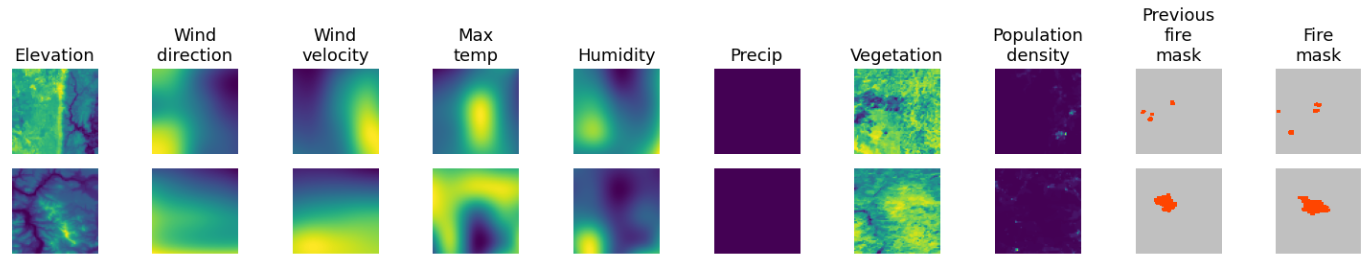

## Training part

### Training parameters

In [ ]:
MIN_PIXEL_FIRE = 15
BATCH_SIZE = 32
WEIGHT = 3
EPOCHS = 15
LEARNING_RATE = 1e-4
EXPERIMENT_FOLDER = 'res'


### Loading datasets

Because the dataset is made for an US purpose and our case study is based on Greece some parameters were not available as ERC so we only consider the following parameters for the training : Elevation, Wind direction, Wind velocity, Maximum temperature, Humidity, Precipitation, Vegetation, Population density, Previous fire mask and Fire mask.

In [ ]:
INPUT_FEATURES = ['elevation', 'th', 'vs',  'tmmn', 'tmmx', 'sph', 
                  'pr', 'pdsi', 'NDVI', 'population', 'erc', 'PrevFireMask']
OUTPUT_FEATURES = ['FireMask']
TITLES = ['Elevation','Wind\ndirection','Wind\nvelocity','Min\ntemp','Max\ntemp','Humidity','Precip','Drought','Vegetation','Population\ndensity','Energy\nrelease\ncomponent','Previous\nfire\nmask','Fire\nmask']



def normalize_feature(feature, feature_name):
    """
    Normalization of input features based on their type.

    Args:
        feature (Tensor): The feature tensor to be normalized.
        feature_name (str): Name of the feature, used to determine the type.

    Returns:
        Tensor: The normalized feature. For 'PrevFireMask', the feature is returned unchanged.
                Other features are normalized to the range [-1, 1].
    """
    if feature_name == 'PrevFireMask':
        # Fire mask is already binary
        feature =tf.where(feature > 0.9, 1.0, 0.0)

        return feature
    else:
        # Normalize other features to [-1, 1] range
        return (feature - tf.reduce_mean(feature)) / (tf.math.reduce_std(feature) + 1e-6)

def _parse_function(example_proto):

    """
    Parsing and preprocessing of a serialized TFRecord example.

    Args:
        example_proto (Tensor): A serialized TFRecord example.

    Returns:
        Tuple[Tensor, Tensor]: 
            - inputs: A tensor containing concatenated and normalized input features 
                      with shape [64, 64, num_features].
            - label: A tensor containing the processed FireMask label with shape [64, 64, 1].
    """
    # Feature description dictionary: specifies the shape and types of features
    feature_description = {}
    for feature_name in INPUT_FEATURES + OUTPUT_FEATURES:
        feature_description[feature_name] = tf.io.FixedLenFeature([64, 64], tf.float32)

    # Parse the input tf.train.Example proto using the dictionary above
    parsed_example = tf.io.parse_single_example(example_proto, feature_description)

    # Create a single tensor from the input features 
    inputs_list = []
    for feature_name in INPUT_FEATURES:
       
        feature = tf.expand_dims(parsed_example[feature_name], axis=-1) # Expand dimensions to make sure each feature has shape [64, 64, 1]
        normalized_feature = normalize_feature(feature, feature_name)
        if feature_name not in ["tmmn", "erc", "pdsi"]:
            if feature_name == "PrevFireMask":
                prev_fire_mask_input =normalized_feature
            inputs_list.append(normalized_feature)
    inputs = tf.concat(inputs_list, axis=-1)  # Shape of inputs: [64, 64, 9] 
    # The label (FireMask), is expanded to have a shape [64,64,1]
    
    label = tf.expand_dims(parsed_example['FireMask'], axis=-1)  # Shape of output: [64, 64, 1]
    
    label = tf.where(label < 0, 0.0, label)
    label = tf.where(label > 0, 1.0, label)

    num_pixels_with_fire = tf.reduce_sum(prev_fire_mask_input)
    is_valid_example = num_pixels_with_fire >= MIN_PIXEL_FIRE 
    # Check if the number of pixels with fire is greater than or equal to MIN_PIXEL_FIRE

    return inputs, label, is_valid_example

def get_dataset(file_pattern: Text, batch_size: int) -> tf.data.Dataset: 

    """
    Creation and preprocessing of a dataset for training or evaluation.

    Args:
        file_pattern (Text): File path pattern to match TFRecord files.
        batch_size (int): Number of samples per batch.

    Returns:
        tf.data.Dataset: A preprocessed dataset with shuffled, batched, and prefetched data.
    """
    
    dataset = tf.data.Dataset.list_files(file_pattern) #Creates a dataset of filepaths matching file_pattern, which each filepath representing a TFRecord file 
    dataset = dataset.interleave(
        lambda x: tf.data.TFRecordDataset(x), # Opens file and creates a TFRecordDataset, which reads the serialized examples from the file.
        num_parallel_calls=tf.data.AUTOTUNE   # enable automatic parallel processing
        )
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE) # parse the serialized data in each TFRecord to split inputs and labels (see previous cell)
    
    dataset = dataset.filter(lambda inputs, label, is_valid: is_valid)
    dataset = dataset.map(lambda inputs, label, is_valid: (inputs, label))



    dataset = dataset.shuffle(buffer_size=1000) # Randomly shuffles the data by using a buffer of size 1000 (random samples are taken from buffer)
    dataset = dataset.batch(batch_size) # Batch = subset of data the we expose the model to during training 
    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE) # speeds up training by overlapping preprocessing and model execution  
    return dataset


    
train_file = '../../data/training_dataset_firespread_model/next_day_wildfire_spread_train*'
test_file = '../../data/training_dataset_firespread_model/next_day_wildfire_spread_test*'
validation_file = '../../data/training_dataset_firespread_model/next_day_wildfire_spread_eval*'

train_dataset = get_dataset(train_file, batch_size=BATCH_SIZE)
validation_dataset = get_dataset(validation_file, batch_size= BATCH_SIZE)
test_dataset = get_dataset(test_file,batch_size= BATCH_SIZE)

### CNN model

This CNN model is inspired by the model used in the https://ieeexplore.ieee.org/abstract/document/9840400.


In [ ]:
def build_model_res():
    input_shape=(64, 64, 9)
    inputs = tf.keras.Input(shape=input_shape)

    # Initial Conv block
    x = layers.Conv2D(16, 3, padding='same')(inputs)
    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(16, 3, padding='same')(x)
    x = layers.Dropout(0.1)(x)

    shortcut = layers.Conv2D(16, kernel_size=1, padding='same')(inputs)
    shortcut = layers.Dropout(0.1)(shortcut)
    x = layers.Add()([x, shortcut])

    # ResBlocks down
    x = ResBlock(x, filters=32, downsample='maxpool')
    x = ResBlock(x, filters=32, downsample='maxpool')

    # ResBlocks up
    x = layers.UpSampling2D()(x)
    x = ResBlock(x, filters=16, downsample='conv')
    x = layers.UpSampling2D()(x)
    x = ResBlock(x, filters=16, downsample='conv')

    # Output layer
    outputs = layers.Conv2D(1, 1, activation='sigmoid')(x)

    return tf.keras.Model(inputs, outputs)


def ResBlock(inputs, filters, downsample='maxpool'):
    x = layers.LeakyReLU()(inputs)
    x = layers.Dropout(0.1)(x)

    if downsample == 'maxpool':
        x = layers.MaxPooling2D(pool_size=(2, 2))(x)
        shortcut = layers.MaxPooling2D(pool_size=(2, 2))(inputs)
        shortcut = layers.Conv2D(filters, kernel_size=1, padding='same')(shortcut)
    elif downsample == 'conv':
        x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
        shortcut = layers.Conv2D(filters, kernel_size=1, strides=1, padding='same')(inputs)
    else:
        shortcut = inputs  #No downsample

    x = layers.LeakyReLU()(x)
    x = layers.Dropout(0.1)(x)
    x = layers.Conv2D(filters, kernel_size=3, padding='same')(x)
    x = layers.Dropout(0.1)(x)

    shortcut = layers.Dropout(0.1)(shortcut)
    return layers.Add()([x, shortcut])

### Plot the fire prediction from the test dataset.

In [ ]:
def show_inference(n_rows: int, features: tf.Tensor, label: tf.Tensor, prediction_function: 
    Callable[[tf.Tensor], tf.Tensor],save_path) -> None:
    """Show model inference through images.
    
    Args:
        n_rows (int): Number of rows for subplots.
        features (tf.Tensor): Input features.
        label (tf.Tensor): True labels.
        prediction_function (Callable[[tf.Tensor], tf.Tensor]): Function for model prediction.
    """
    
    # Variables for controllong the color map for the fire masks
    CMAP = colors.ListedColormap(['black', 'silver', 'orangered'])
    BOUNDS = [-1, -0.1, 0.001, 1]
    NORM = colors.BoundaryNorm(BOUNDS, CMAP.N)
    
    fig = plt.figure(figsize=(15,n_rows*4))
    
    prediction = prediction_function(features)
    for i in range(n_rows):
        plt.subplot(n_rows, 3, i*3 + 1)
        plt.title("Previous day fire")
        plt.imshow(features[i, :, :, -1], cmap=CMAP, norm=NORM)
        plt.axis('off')
        plt.subplot(n_rows, 3, i*3 + 2)
        plt.title("True next day fire")
        plt.imshow(label[i, :, :, 0], cmap=CMAP, norm=NORM)
        plt.axis('off')
        plt.subplot(n_rows, 3, i*3 + 3)
        plt.title("Predicted next day fire")
        plt.imshow(prediction[i, :, :],cmap=CMAP, norm=NORM)
        plt.axis('off')    
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

### Assess the model results

To assess the model we use precision, recall and AUC.

In [ ]:
def plot_history(history, save_path):
    """Display curves of loss et accuracy"""
    plt.figure(figsize=(12, 10))

    # Loss
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curve')

    if 'auc' in history.history:
        plt.subplot(2, 2, 2)
        plt.plot(history.history['auc'], label='Auc ')
        plt.plot(history.history['val_auc'], label='Val AUC')
        plt.xlabel('Epochs')
        plt.ylabel('AUC')
        plt.title('Training & Validation AUC')
        plt.legend()
    
    if 'precision' in history.history:
        plt.subplot(2, 2, 3)
        plt.plot(history.history['precision'], label='Precision train ')
        plt.plot(history.history['val_precision'], label='Val precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.title('Training & Validation Precision')
        plt.legend()

    if 'recall' in history.history:
        plt.subplot(2, 2,4 )
        plt.plot(history.history['recall'], label='recall train ')
        plt.plot(history.history['val_recall'], label='Val recall')
        plt.xlabel('Epochs')
        plt.ylabel('recall')
        plt.title('Training & Validation recall')
        plt.legend()

    plt.savefig(save_path)  # Register image
    plt.close()

# Training 

Because our training images contain far more non-fire pixels than fire pixels, we assign a higher weight to correct predictions on fire pixels.

In [ ]:
@register_keras_serializable()
def weighted_binary_crossentropy(y_true, y_pred):
    weight_0=1
    weight_1=WEIGHT
    """Add ponderation to classes 0 and 1 (no fire and fire)"""
    epsilon = tf.keras.backend.epsilon()  # To avoid log(0)
    y_pred = tf.keras.backend.clip(y_pred, epsilon, 1.0 - epsilon)
    loss = - (weight_1 * y_true * tf.keras.backend.log(y_pred) + 
            weight_0 * (1 - y_true) * tf.keras.backend.log(1 - y_pred))
    return tf.keras.backend.mean(loss)


In [ ]:
model =build_model_res()
model.compile(optimizer=Adam(LEARNING_RATE), loss=weighted_binary_crossentropy , metrics=[AUC(),Precision(), Recall()])
model.summary()

#Training
tf.random.set_seed(1337)

history =model.fit(train_dataset,
                    epochs=EPOCHS,
                    batch_size = BATCH_SIZE,
                    validation_data = validation_dataset)
        
val_loss = history.history['val_loss'][-1] 
auc = history.history.get('val_auc', [0])[-1]
precision = history.history.get('val_precision', [0])[-1]
recall = history.history.get('val_recall', [0])[-1]

Display training results and save the model

In [ ]:
os.makedirs(f"example/{EXPERIMENT_FOLDER}_evaluation", exist_ok=True)
save_file_history =f"example/{EXPERIMENT_FOLDER}_evaluation/h_{EPOCHS}_{BATCH_SIZE}_{LEARNING_RATE}_{MIN_PIXEL_FIRE}_{WEIGHT}.png"
plot_history(history,save_file_history)

os.makedirs(f"example/{EXPERIMENT_FOLDER}", exist_ok=True)
model.save(f"example/{EXPERIMENT_FOLDER}/saved_model_{EPOCHS}_{BATCH_SIZE}_{LEARNING_RATE}_{MIN_PIXEL_FIRE}_{WEIGHT}.keras")
results_file = f"example/{EXPERIMENT_FOLDER}_evaluation/metrics_results.txt"

with open(results_file, "a") as f:  # "a" = append mode, add without erasing 
    f.write(f"AUC:{auc}, Val_loss:{val_loss}, Precision: {precision}, Recall: {recall}, Weight:{WEIGHT}, Epochs: {EPOCHS}, Batch Size: {BATCH_SIZE}, Learning Rate: {LEARNING_RATE},MinPixels:{MIN_PIXEL_FIRE}\n")
    f.flush() 
print(f"IoU Score saved in {results_file}")

os.makedirs(f"example/{EXPERIMENT_FOLDER}_samples", exist_ok=True)
save_path = f"./example/{EXPERIMENT_FOLDER}_samples/plot_{EPOCHS}_{BATCH_SIZE}_{LEARNING_RATE}_{MIN_PIXEL_FIRE}_{WEIGHT}.png"

features, labels = next(iter(test_dataset))
show_inference(6, features, labels, lambda x: tf.where(model.predict(x) > 0.5, 1, 0)[:,:,:,0],save_path)  

## Output from the model

In this section, we load the satellite images of the Greece fire collected using the "collect_environment_parameters.py" notebook, and feed them into the model to obtain a prediction of the fire spread for the next day. The output image will notably be used to assess the severity of the fire.

In [ ]:
model = tf.keras.models.load_model(f"example/{EXPERIMENT_FOLDER}/saved_model_{EPOCHS}_{BATCH_SIZE}_{LEARNING_RATE}_{MIN_PIXEL_FIRE}_{WEIGHT}.keras")

input_array_file = 'example/array_extracted.npy'
input_array = np.load(input_array_file, allow_pickle=True)

for i in range(8):
    input_array[:, :, i] = (input_array[:, :, i] - np.mean(input_array[:, :, i])) / (np.std(input_array[:, :, i]) + 1e-6)

input_array_batch = np.expand_dims(input_array, axis=0)  # (1, 64, 64, 9)

        
predictions = model.predict(input_array_batch)  # shape: (1, 64, 64, 1)
binary_predictions = (predictions > 0.5).astype(np.uint8)
output_image = binary_predictions[0]  # shape: (64, 64, 1)
output_image_2d = output_image.squeeze()  # shape: (64, 64)

plt.imshow(output_image_2d, cmap='gray')
plt.title("Prediction")
plt.colorbar()
plt.savefig("example/output_prediction.png")
plt.show()

In order to get a severity score from the predicted fire we compare the number of pixels in fire between our output image and the predictions from the test dataset. We do a normalisation with the rank in order to avoid the effect of outliers on the final score.

In [ ]:
predictions = model.predict(test_dataset)  # shape: (1, 64, 64, 1)
fire_pixel_counts = []
burned_area_pixels_output = np.sum(output_image_2d.squeeze()) 


for data_image in predictions:
    binary_image = np.squeeze(data_image)  
    burned_area_pixels = np.sum(binary_image)  # Count the number of pixels in fire
    fire_pixel_counts.append(burned_area_pixels)

# Convert to numpy array for numerical operations
fire_pixel_counts.append(burned_area_pixels_output)
fire_pixel_counts = np.array(fire_pixel_counts)

# Use the rank for the normalisation to avoid effects of outliers.
ranks = rankdata(fire_pixel_counts, method='average')
severity_scores = 1 + 99 * (ranks - 1) / (len(ranks) - 1)
severity_scores = severity_scores.astype(int)
severity_score_output = severity_scores[-1] # Get the score of the output image
print("The severity score of the output image is:", severity_score_output)